In [1]:
print(
"""
************************************************************
Author: Shota DEGUCHI
        Strucural Analysis Lab. Kyushu Uni. (July 19, 2021)
************************************************************
""")

import sys
import os
import cProfile
import pstats
import time
import datetime
import tensorflow as tf
from tensorflow.python.client import device_lib
import numpy as np
import pandas as pd
import scipy.io
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
# import seaborn as sns

print("current python version:", sys.version)
print("        tf     version:", tf.__version__)

lr      = 1e-3
c_tol   = 1e-5
n_btch  = 2 ** 7   # 2 ** x: 5 => 32, 6 => 64, 7 => 128, 8 => 256
n_epch  = int(1e4)
f_mntr  = int(1e1)
layers  = [3] + 7 * [30] + [3]
layers  = [3] + 7 * [200] + [3]
gpu_flg = 1   # 0, 1, or 2 (see: https://www.tensorflow.org/guide/gpu)
              # 0: Restrict TensorFlow to only use the first GPU
              # 1: Find the first GPU, and restrict the memory usage (adaptive)
              # 2: Create 2 virtual GPUs with 1GB memory each

seed    = 1234
np.random.seed(seed)
tf.random.set_seed(seed)


************************************************************
Author: Shota DEGUCHI
        Strucural Analysis Lab. Kyushu Uni. (July 19, 2021)
************************************************************

current python version: 3.6.9 (default, Jan 26 2021, 15:33:00) 
[GCC 8.4.0]
        tf     version: 2.5.0


In [2]:
#gpu configuration

tf.debugging.set_log_device_placement(False)   # True to check executing device carefully
gpus = tf.config.experimental.list_physical_devices("GPU")

if gpu_flg == 0:
    print("gpu_flg:", gpu_flg)
    if gpus:
        # Restrict TensorFlow to only use the first GPU
        try:
            tf.config.experimental.set_visible_devices(gpus[0], "GPU")
            logical_gpus = tf.config.experimental.list_logical_devices("GPU")
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
        except RuntimeError as e:
            # Visible devices must be set before GPUs have been initialized
            print(e)
    
elif gpu_flg == 1:
    print("gpu_flg:", gpu_flg)
    if gpus:
        # Find the first GPU, and restrict the memory usage (adaptive)
        try:
            tf.config.experimental.set_visible_devices(gpus[0], "GPU")
            tf.config.experimental.set_memory_growth(gpus[0], True)
            logical_gpus = tf.config.experimental.list_logical_devices("GPU")
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
            print("\nDevice information;")
            print(device_lib.list_local_devices())
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e)

elif gpu_flg == 2:
    print("gpu_flg:", gpu_flg)
    if gpus:
        # Create 2 virtual GPUs with 1GB memory each
        try:
            tf.config.experimental.set_virtual_device_configuration(
                gpus[0],
                [tf.config.experimental.VirtualDeviceConfiguration(memory_limit = 2 ** 10),
                 tf.config.experimental.VirtualDeviceConfiguration(memory_limit = 2 ** 10)])
            logical_gpus = tf.config.experimental.list_logical_devices("GPU")
            print(len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPUs")
            print("\nDevice information;")
            print(device_lib.list_local_devices())
        except RuntimeError as e:
            # Virtual devices must be set before GPUs have been initialized
            print(e)

else:
    print(">>>>> ERROR: gpu_flg not specified properly")

gpu_flg: 1
2 Physical GPUs, 1 Logical GPUs

Device information;
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 756179643220614503
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 47749464064
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1736301010809937513
physical_device_desc: "device: 0, name: RTX A6000, pci bus id: 0000:81:00.0, compute capability: 8.6"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 2782724096
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4993972312010591973
physical_device_desc: "device: 1, name: Quadro P2200, pci bus id: 0000:c1:00.0, compute capability: 6.1"
]


In [3]:
class PINN_fullbatch:
    def __init__(self, 
                 x_trn, y_trn, t_trn, u_trn, v_trn, 
                 x_val, y_val, t_val, u_val, v_val, 
                 layers, activ = "tanh", w_init = "Glorot", 
                 lr = 1e-3, opt = "Adam", 
                 w_prd = 1., w_pde = 1.):
        
        # initialize the configuration
        self.dtype  = tf.float32
        self.layers = layers
        self.activ  = activ    # selects activation function (tanh / swish / etc.)
        self.w_init = w_init   # selects weight initializer (Glorot / He / LeCun)
        self.weights, self.biases, self.params = self.initialize_NN(layers)
        self.lr  = lr
        self.opt = opt
        self.optimizer = self.optimizer(self.lr, self.opt)   # optimizer (e.g. SGD / Adam / RMSprop / etc.)
        
        # bounds
        X_trn   = tf.concat([x_trn, y_trn, t_trn], 1)
        self.lb = tf.cast(tf.reduce_min(X_trn, axis = 0), self.dtype)
        self.ub = tf.cast(tf.reduce_max(X_trn, axis = 0), self.dtype)
        
        # training set
        self.x_trn = x_trn; self.y_trn = y_trn; self.t_trn = t_trn
        self.u_trn = u_trn; self.v_trn = v_trn
        
        # validation set
        self.x_val = x_val; self.y_val = y_val; self.t_val = t_val
        self.u_val = u_val; self.v_val = v_val
        
        # weight for loss terms
        self.w_prd = w_prd
        self.w_pde = w_pde
        
        # parameter setting
        self.rho = tf.constant(1,   dtype = self.dtype)
        self.nu  = tf.constant(.01, dtype = self.dtype)
        
        # track loss
        self.ep_log   = []
        self.loss_log = []

    def optimizer(self, lr, opt):
        if   opt == "SGD":
            optimizer = tf.keras.optimizers.SGD(learning_rate = lr, momentum = 0.0, nesterov = False)
        elif opt == "Adadelta":
            optimizer = tf.keras.optimizers.Adadelta(learning_rate = lr, rho = 0.95)
        elif opt == "Adagrad":
            optimizer = tf.keras.optimizers.Adagrad(learning_rate = lr, initial_accumulator_value = 0.1)
        elif opt == "RMSprop":
            optimizer = tf.keras.optimizers.RMSprop(learning_rate = lr, rho = 0.9, momentum = 0.0, centered = False)
        elif opt == "Adam":
            optimizer = tf.keras.optimizers.Adam(learning_rate = lr, beta_1 = 0.9, beta_2 = 0.999, amsgrad = False)
        elif opt == "Adamax":
            optimizer = tf.keras.optimizers.Adamax(learning_rate = lr, beta_1 = 0.9, beta_2 = 0.999)
        elif opt == "Nadam":
            optimizer = tf.keras.optimizers.Nadam(learning_rate = lr, beta_1 = 0.9, beta_2 = 0.999)
        else:
            raise Exception(">>>>> Exception: optimizer not specified correctly")
            
        return optimizer
    
    def initialize_NN(self, layers):
        weights = []
        biases  = []
        params  = []
        
        num_layers = len(layers) 
        for l in range(0, num_layers - 1):
            W = self.weight_init(size = [layers[l], layers[l + 1]], depth = l)
            b = tf.Variable(tf.zeros([1, layers[l + 1]], dtype = self.dtype), dtype = self.dtype, name = "b" + str(l))
            weights.append(W)
            biases.append(b)
            params.append(W)
            params.append(b)
            
        return weights, biases, params
        
    def weight_init(self, size, depth):
        w_init  = self.w_init
        in_dim  = size[0]
        out_dim = size[1]
        
        if   w_init == "Glorot":
            stdev = np.sqrt(2 / (in_dim + out_dim))
        elif w_init == "He":
            stdev = np.sqrt(2 / in_dim)
        elif w_init == "LeCun":
            stdev = np.sqrt(1 / in_dim)
        else:
            raise Exception(">>>>> Exception: weight initializer not specified correctly")
        
        return tf.Variable(tf.random.truncated_normal([in_dim, out_dim], stddev = stdev, dtype = self.dtype), dtype = self.dtype, name = "W" + str(depth))
    
    def neural_net(self, X, weights, biases):   # forward pass
        activ = self.activ
        num_layers = len(weights) + 1
        Z = 2. * (X - self.lb) / (self.ub - self.lb) - 1.
        
        for l in range(0, num_layers - 2):
            W = weights[l]
            b = biases[l]
            U = tf.add(tf.matmul(Z, W), b)
            
            if activ == "tanh":
                Z = tf.tanh(U)
            elif activ == "gelu":
                Z = tf.multiply(U, tf.sigmoid(1.702 * U))
            elif activ == "silu" or activ == "swish-1":
                Z = tf.multiply(U, tf.sigmoid(U))
            elif activ == "mish":
                Z = tf.multiply(U, tf.tanh(tf.nn.softplus(U)))
            else:
                raise Exception(">>>>> Exception: activation function not specified correctly")
        
        W = weights[-1]
        b = biases[-1]
        U = tf.add(tf.matmul(Z, W), b)
        Z = U   # identity mapping for the last layer
        Y = Z
        return Y
        
    def PDE(self, x, y, t):
        rho = self.rho
        nu  = self.nu
        
        x = tf.convert_to_tensor(x, dtype = self.dtype)
        y = tf.convert_to_tensor(y, dtype = self.dtype)
        t = tf.convert_to_tensor(t, dtype = self.dtype)

        with tf.GradientTape(persistent = True) as tp:
            tp.watch(x)
            tp.watch(y)
            tp.watch(t)
            
            u_v_p = self.neural_net(tf.concat([x, y, t], 1), self.weights, self.biases)
            u = u_v_p[:,0:1]
            v = u_v_p[:,1:2]
            p = u_v_p[:,2:3]
            
            u_x = tp.gradient(u, x); u_y = tp.gradient(u, y)
            v_x = tp.gradient(v, x); v_y = tp.gradient(v, y)
            
        u_t  = tp.gradient(u, t);   v_t  = tp.gradient(v, t)
        u_xx = tp.gradient(u_x, x); u_yy = tp.gradient(u_y, y)
        v_xx = tp.gradient(v_x, x); v_yy = tp.gradient(v_y, y)
        p_x  = tp.gradient(p, x);   p_y  = tp.gradient(p, y)
        
        del tp
        
        gv_c = u_x + v_y                                                   # continuity
        gv_x = u_t + u * u_x + v * u_y + p_x / rho - nu * (u_xx + u_yy)   # momentum
        gv_y = v_t + u * v_x + v * v_y + p_y / rho - nu * (v_xx + v_yy)
        
        return u, v, p, gv_c, gv_x, gv_y

    def loss_prd(self, x, y, t, u, v):
        u_hat, v_hat, p_hat, dummy, dummy, dummy = self.PDE(x, y, t)
        loss_prd =    tf.reduce_mean(tf.square(u - u_hat)) \
                    + tf.reduce_mean(tf.square(v - v_hat))
        loss_prd = self.w_prd * loss_prd
        
        return loss_prd
        
    def loss_pde(self, x, y, t):
        dummy, dummy, dummy, gv_c_hat, gv_x_hat, gv_y_hat = self.PDE(x, y, t)
        
        loss_pde =    tf.reduce_mean(tf.square(gv_c_hat)) \
                    + tf.reduce_mean(tf.square(gv_x_hat)) \
                    + tf.reduce_mean(tf.square(gv_y_hat))
        loss_pde = self.w_pde * loss_pde
        
        return loss_pde
    
    def loss_glb(self, x, y, t, u, v):
        loss_glb = self.loss_prd(x, y, t, u, v) + self.loss_pde(x, y, t)
        
        return loss_glb

    def loss_grad(self, x, y, t, u, v):
        with tf.GradientTape(persistent = True) as tp:
            loss = self.loss_glb(x, y, t, u, v)
        grad = tp.gradient(loss, self.params)
        del tp

        return loss, grad
    
    @tf.function
    def grad_desc(self, x, y, t, u, v):
        loss, grad = self.loss_grad(x, y, t, u, v)
        self.optimizer.apply_gradients(zip(grad, self.params))
        
        return loss
        
#     def train(self, epoch = 10 ** 5, batch = 2 ** 6, tol = 1e-5): 
    def train(self, epoch = 10 ** 5, tol = 1e-5): 
        # training set
        x_trn = tf.convert_to_tensor(self.x_trn, dtype = self.dtype)
        y_trn = tf.convert_to_tensor(self.y_trn, dtype = self.dtype)
        t_trn = tf.convert_to_tensor(self.t_trn, dtype = self.dtype)
        u_trn = tf.convert_to_tensor(self.u_trn, dtype = self.dtype)
        v_trn = tf.convert_to_tensor(self.v_trn, dtype = self.dtype)
        
        # validation set
        x_val = tf.convert_to_tensor(self.x_val, dtype = self.dtype)
        y_val = tf.convert_to_tensor(self.y_val, dtype = self.dtype)
        t_val = tf.convert_to_tensor(self.t_val, dtype = self.dtype)
        u_val = tf.convert_to_tensor(self.u_val, dtype = self.dtype)
        v_val = tf.convert_to_tensor(self.v_val, dtype = self.dtype)
        
        t0 = time.time()
        n_data = self.x_trn.shape[0]
        
        for ep in range(epoch):
            
            ep_loss_trn = self.grad_desc(x_trn, y_trn, t_trn, u_trn, v_trn)
            
            if ep % f_mntr == 0:
                elps = time.time() - t0
                
                self.ep_log.append(ep)
                self.loss_log.append(ep_loss_trn)
                
                print("ep: %d, loss_trn: %.6e, elps: %.3f" % (ep, ep_loss_trn, elps))
                t0 = time.time()
            
            if ep == 0:
                ep0_loss_trn = self.loss_glb(x_trn, y_trn, t_trn, u_trn, v_trn)
                ep0_loss_val = self.loss_glb(x_val, y_val, t_val, u_val, v_val)
                print(">>>>> initial state; loss_trn: %.6e, loss_val: %.6e" % (ep0_loss_trn, ep0_loss_val))
                
#             if ep % f_mntr == 0:
#                 elps = time.time() - t0
#                 print("ep: %d, loss_trn: %.6e, loss_val: %.6e, elps: %.3f" % (ep, ep_loss_trn, ep_loss_val, elps))
#                 t0 = time.time()
                
            if ep_loss_trn < tol:
                print(">>>>> program terminating with the loss converging to its tolerance.")
                break
        
    def predict(self, x, y, t):
        u_hat, v_hat, p_hat, gv_c_hat, gv_x_hat, gv_y_hat = self.PDE(x, y, t)
        return u_hat, v_hat, p_hat, gv_c_hat, gv_x_hat, gv_y_hat

In [4]:
class PINN_minibatch:
    def __init__(self, 
                 x_trn, y_trn, t_trn, u_trn, v_trn, 
                 x_val, y_val, t_val, u_val, v_val, 
                 layers, activ = "tanh", w_init = "Glorot", 
                 lr = 1e-3, opt = "Adam", 
                 w_prd = 1., w_pde = 1.):
        
        # initialize the configuration
        self.dtype  = tf.float32
        self.layers = layers
        self.activ  = activ    # selects activation function (tanh / swish / etc.)
        self.w_init = w_init   # selects weight initializer (Glorot / He / LeCun)
        self.weights, self.biases, self.params = self.initialize_NN(layers)
        self.lr  = lr
        self.opt = opt
        self.optimizer = self.optimizer(self.lr, self.opt)   # optimizer (e.g. SGD / Adam / RMSprop / etc.)
        
        # bounds
        X_trn   = tf.concat([x_trn, y_trn, t_trn], 1)
        self.lb = tf.cast(tf.reduce_min(X_trn, axis = 0), self.dtype)
        self.ub = tf.cast(tf.reduce_max(X_trn, axis = 0), self.dtype)
        
        # training set
        self.x_trn = x_trn; self.y_trn = y_trn; self.t_trn = t_trn
        self.u_trn = u_trn; self.v_trn = v_trn
        
        # validation set
        self.x_val = x_val; self.y_val = y_val; self.t_val = t_val
        self.u_val = u_val; self.v_val = v_val
        
        # weight for loss terms
        self.w_prd = w_prd
        self.w_pde = w_pde
        
        # parameter setting
        self.rho = tf.constant(1,   dtype = self.dtype)
        self.nu  = tf.constant(.01, dtype = self.dtype)
        
        # track loss
        self.ep_log   = []
        self.loss_log = []

    def optimizer(self, lr, opt):
        if   opt == "SGD":
            optimizer = tf.keras.optimizers.SGD(learning_rate = lr, momentum = 0.0, nesterov = False)
        elif opt == "Adadelta":
            optimizer = tf.keras.optimizers.Adadelta(learning_rate = lr, rho = 0.95)
        elif opt == "Adagrad":
            optimizer = tf.keras.optimizers.Adagrad(learning_rate = lr, initial_accumulator_value = 0.1)
        elif opt == "RMSprop":
            optimizer = tf.keras.optimizers.RMSprop(learning_rate = lr, rho = 0.9, momentum = 0.0, centered = False)
        elif opt == "Adam":
            optimizer = tf.keras.optimizers.Adam(learning_rate = lr, beta_1 = 0.9, beta_2 = 0.999, amsgrad = False)
        elif opt == "Adamax":
            optimizer = tf.keras.optimizers.Adamax(learning_rate = lr, beta_1 = 0.9, beta_2 = 0.999)
        elif opt == "Nadam":
            optimizer = tf.keras.optimizers.Nadam(learning_rate = lr, beta_1 = 0.9, beta_2 = 0.999)
        else:
            raise Exception(">>>>> Exception: optimizer not specified correctly")
            
        return optimizer
    
    def initialize_NN(self, layers):
        weights = []
        biases  = []
        params  = []
        
        num_layers = len(layers) 
        for l in range(0, num_layers - 1):
            W = self.weight_init(size = [layers[l], layers[l + 1]], depth = l)
            b = tf.Variable(tf.zeros([1, layers[l + 1]], dtype = self.dtype), dtype = self.dtype, name = "b" + str(l))
            weights.append(W)
            biases.append(b)
            params.append(W)
            params.append(b)
            
        return weights, biases, params
        
    def weight_init(self, size, depth):
        w_init  = self.w_init
        in_dim  = size[0]
        out_dim = size[1]
        
        if   w_init == "Glorot":
            stdev = np.sqrt(2 / (in_dim + out_dim))
        elif w_init == "He":
            stdev = np.sqrt(2 / in_dim)
        elif w_init == "LeCun":
            stdev = np.sqrt(1 / in_dim)
        else:
            raise Exception(">>>>> Exception: weight initializer not specified correctly")
        
        return tf.Variable(tf.random.truncated_normal([in_dim, out_dim], stddev = stdev, dtype = self.dtype), dtype = self.dtype, name = "W" + str(depth))
    
    def neural_net(self, X, weights, biases):   # forward pass
        activ = self.activ
        num_layers = len(weights) + 1
        Z = 2. * (X - self.lb) / (self.ub - self.lb) - 1.
        
        for l in range(0, num_layers - 2):
            W = weights[l]
            b = biases[l]
            U = tf.add(tf.matmul(Z, W), b)
            
            if activ == "tanh":
                Z = tf.tanh(U)
            elif activ == "gelu":
                Z = tf.multiply(U, tf.sigmoid(1.702 * U))
            elif activ == "silu" or activ == "swish-1":
                Z = tf.multiply(U, tf.sigmoid(U))
            elif activ == "mish":
                Z = tf.multiply(U, tf.tanh(tf.nn.softplus(U)))
            else:
                raise Exception(">>>>> Exception: activation function not specified correctly")
        
        W = weights[-1]
        b = biases[-1]
        U = tf.add(tf.matmul(Z, W), b)
        Z = U   # identity mapping for the last layer
        Y = Z
        return Y
        
    def PDE(self, x, y, t):
        rho = self.rho
        nu  = self.nu
        
        x = tf.convert_to_tensor(x, dtype = self.dtype)
        y = tf.convert_to_tensor(y, dtype = self.dtype)
        t = tf.convert_to_tensor(t, dtype = self.dtype)

        with tf.GradientTape(persistent = True) as tp:
            tp.watch(x)
            tp.watch(y)
            tp.watch(t)
            
            u_v_p = self.neural_net(tf.concat([x, y, t], 1), self.weights, self.biases)
            u = u_v_p[:,0:1]
            v = u_v_p[:,1:2]
            p = u_v_p[:,2:3]
            
            u_x = tp.gradient(u, x); u_y = tp.gradient(u, y)
            v_x = tp.gradient(v, x); v_y = tp.gradient(v, y)
            
        u_t  = tp.gradient(u, t);   v_t  = tp.gradient(v, t)
        u_xx = tp.gradient(u_x, x); u_yy = tp.gradient(u_y, y)
        v_xx = tp.gradient(v_x, x); v_yy = tp.gradient(v_y, y)
        p_x  = tp.gradient(p, x);   p_y  = tp.gradient(p, y)
        
        del tp
        
        gv_c = u_x + v_y                                                  # continuity
        gv_x = u_t + u * u_x + v * u_y + p_x / rho - nu * (u_xx + u_yy)   # momentum
        gv_y = v_t + u * v_x + v * v_y + p_y / rho - nu * (v_xx + v_yy)
        
        return u, v, p, gv_c, gv_x, gv_y

    def loss_prd(self, x, y, t, u, v):
        u_hat, v_hat, p_hat, dummy, dummy, dummy = self.PDE(x, y, t)
        loss_prd =    tf.reduce_mean(tf.square(u - u_hat)) \
                    + tf.reduce_mean(tf.square(v - v_hat))
        loss_prd = self.w_prd * loss_prd
        
        return loss_prd
        
    def loss_pde(self, x, y, t):
        dummy, dummy, dummy, gv_c_hat, gv_x_hat, gv_y_hat = self.PDE(x, y, t)
        
        loss_pde =    tf.reduce_mean(tf.square(gv_c_hat)) \
                    + tf.reduce_mean(tf.square(gv_x_hat)) \
                    + tf.reduce_mean(tf.square(gv_y_hat))
        loss_pde = self.w_pde * loss_pde
        
        return loss_pde
    
    def loss_glb(self, x, y, t, u, v):
        loss_glb = self.loss_prd(x, y, t, u, v) + self.loss_pde(x, y, t)
        
        return loss_glb

    def loss_grad(self, x, y, t, u, v):
        with tf.GradientTape(persistent = True) as tp:
            loss = self.loss_glb(x, y, t, u, v)
        grad = tp.gradient(loss, self.params)
        del tp

        return loss, grad
    
    @tf.function
    def grad_desc(self, x, y, t, u, v):
        loss, grad = self.loss_grad(x, y, t, u, v)
        self.optimizer.apply_gradients(zip(grad, self.params))
        
        return loss
        
    def train(self, epoch = 10 ** 5, batch = 2 ** 6, tol = 1e-5): 
        # training set
        x_trn = tf.convert_to_tensor(self.x_trn, dtype = self.dtype)
        y_trn = tf.convert_to_tensor(self.y_trn, dtype = self.dtype)
        t_trn = tf.convert_to_tensor(self.t_trn, dtype = self.dtype)
        u_trn = tf.convert_to_tensor(self.u_trn, dtype = self.dtype)
        v_trn = tf.convert_to_tensor(self.v_trn, dtype = self.dtype)
        
        # validation set
        x_val = tf.convert_to_tensor(self.x_val, dtype = self.dtype)
        y_val = tf.convert_to_tensor(self.y_val, dtype = self.dtype)
        t_val = tf.convert_to_tensor(self.t_val, dtype = self.dtype)
        u_val = tf.convert_to_tensor(self.u_val, dtype = self.dtype)
        v_val = tf.convert_to_tensor(self.v_val, dtype = self.dtype)
        
        t0 = time.time()
        n_data = self.x_trn.shape[0]
        
        for ep in range(epoch):
            ep_loss_trn = 0
            shf_idx = np.random.permutation(n_data)
            for idx in range(0, n_data, batch):
                x_trn_btch = self.x_trn[shf_idx[idx: idx + batch if idx + batch < n_data else n_data]]
                y_trn_btch = self.y_trn[shf_idx[idx: idx + batch if idx + batch < n_data else n_data]]
                t_trn_btch = self.t_trn[shf_idx[idx: idx + batch if idx + batch < n_data else n_data]]
                u_trn_btch = self.u_trn[shf_idx[idx: idx + batch if idx + batch < n_data else n_data]]
                v_trn_btch = self.v_trn[shf_idx[idx: idx + batch if idx + batch < n_data else n_data]]
                
                x_trn_btch = tf.convert_to_tensor(x_trn_btch, dtype = self.dtype)
                y_trn_btch = tf.convert_to_tensor(y_trn_btch, dtype = self.dtype)
                t_trn_btch = tf.convert_to_tensor(t_trn_btch, dtype = self.dtype)
                u_trn_btch = tf.convert_to_tensor(u_trn_btch, dtype = self.dtype)
                v_trn_btch = tf.convert_to_tensor(v_trn_btch, dtype = self.dtype)
                
                loss_trn = self.grad_desc(x_trn_btch, y_trn_btch, t_trn_btch, u_trn_btch, v_trn_btch)
                ep_loss_trn += loss_trn
            
            ep_loss_trn = ep_loss_trn / int(n_data / batch)
            
            if ep % f_mntr == 0:
                elps = time.time() - t0
                
                self.ep_log.append(ep)
                self.loss_log.append(ep_loss_trn)
                
                print("ep: %d, loss_trn: %.6e, elps: %.3f" % (ep, ep_loss_trn, elps))
                t0 = time.time()
            
            if ep == 0:
                ep0_loss_trn = self.loss_glb(x_trn, y_trn, t_trn, u_trn, v_trn)
                ep0_loss_val = self.loss_glb(x_val, y_val, t_val, u_val, v_val)
                print(">>>>> initial state; loss_trn: %.6e, loss_val: %.6e" % (ep0_loss_trn, ep0_loss_val))
                
#             if ep % f_mntr == 0:
#                 elps = time.time() - t0
#                 print("ep: %d, loss_trn: %.6e, loss_val: %.6e, elps: %.3f" % (ep, ep_loss_trn, ep_loss_val, elps))
#                 t0 = time.time()
                
            if ep_loss_trn < tol:
                print(">>>>> program terminating with the loss converging to its tolerance.")
                break
        
    def predict(self, x, y, t):
        u_hat, v_hat, p_hat, gv_c_hat, gv_x_hat, gv_y_hat = self.PDE(x, y, t)
        return u_hat, v_hat, p_hat, gv_c_hat, gv_x_hat, gv_y_hat

In [5]:
def plot_sol0(X_star, phi1):
    lb = X_star.min(0); ub = X_star.max(0); nn = 200
    x, y = np.linspace(lb[0], ub[0], nn), np.linspace(lb[1], ub[1], nn); x, y = np.meshgrid(x, y)
    PHI_I = griddata(X_star, phi1.flatten(), (x, y), method = "linear")

    plt.figure(figsize = (8, 3))
    plt.xlabel("x"); plt.ylabel("y")
    plt.xticks(np.arange(-30, 30, 1)); plt.yticks(np.arange(-30, 30, 1))
    plt.pcolor(x, y, PHI_I, cmap = "coolwarm", shading = "auto")
    plt.colorbar()
    
def plot_sol1(X_star, phi1, v0, v1, ticks):
    lb = X_star.min(0); ub = X_star.max(0); nn = 200
    x, y = np.linspace(lb[0], ub[0], nn), np.linspace(lb[1], ub[1], nn); x, y = np.meshgrid(x, y)
    PHI_I = griddata(X_star, phi1.flatten(), (x, y), method = "linear")

    plt.figure(figsize = (8, 3))
    plt.xlabel("x"); plt.ylabel("y")
    plt.xticks(np.arange(-30, 30, 1)); plt.yticks(np.arange(-30, 30, 1))
    plt.pcolor(x, y, PHI_I, cmap = "coolwarm", shading = "auto", vmin = v0, vmax = v1)
    plt.colorbar(ticks = np.arange(-30, 30, ticks))

def plot_sol2(X_star, phi1, phi2, phi3):
    lb = X_star.min(0); ub = X_star.max(0); nn = 200
    x, y = np.linspace(lb[0], ub[0], nn), np.linspace(lb[1], ub[1], nn); x, y = np.meshgrid(x, y)
    PHI_I = griddata(X_star, phi1.flatten(), (x, y), method = "linear")
    PHI_II = griddata(X_star, phi2.flatten(), (x, y), method = "linear")
    PHI_III = griddata(X_star, phi3.flatten(), (x, y), method = "linear")

    plt.figure(figsize = (16, 2))
    plt.subplot(1, 3, 1)
    plt.xlabel("x"); plt.ylabel("y"); plt.title("phi1")
    plt.pcolor(x, y, PHI_I, cmap = "coolwarm", shading = "auto"); plt.colorbar()
    plt.subplot(1, 3, 2)
    plt.xlabel("x"); plt.ylabel("y"); plt.title("phi2")
    plt.pcolor(x, y, PHI_II, cmap = "coolwarm", shading = "auto"); plt.colorbar()
    plt.subplot(1, 3, 3)
    plt.xlabel("x"); plt.ylabel("y"); plt.title("phi3")
    plt.pcolor(x, y, PHI_III, cmap = "coolwarm", shading = "auto"); plt.colorbar()

def plot_sol3(X_star, phi1, phi2, phi3, u0, u1, ut, v0, v1, vt, p0, p1, pt):
    lb = X_star.min(0); ub = X_star.max(0); nn = 200
    x, y = np.linspace(lb[0], ub[0], nn), np.linspace(lb[1], ub[1], nn); x, y = np.meshgrid(x, y)
    PHI_I = griddata(X_star, phi1.flatten(), (x, y), method = "linear")
    PHI_II = griddata(X_star, phi2.flatten(), (x, y), method = "linear")
    PHI_III = griddata(X_star, phi3.flatten(), (x, y), method = "linear")

    plt.figure(figsize = (16, 2))
    plt.subplot(1, 3, 1)
    plt.xlabel("x"); plt.ylabel("y")
    plt.pcolor(x, y, PHI_I, cmap = "coolwarm", shading = "auto", vmin = u0, vmax = u1); plt.colorbar(ticks = np.arange(-3, 3, ut))
    plt.subplot(1, 3, 2)
    plt.xlabel("x"); plt.ylabel("y")
    plt.pcolor(x, y, PHI_II, cmap = "coolwarm", shading = "auto", vmin = v0, vmax = v1); plt.colorbar(ticks = np.arange(-3, 3, vt))
    plt.subplot(1, 3, 3)
    plt.xlabel("x"); plt.ylabel("y")
    plt.pcolor(x, y, PHI_III, cmap = "coolwarm", shading = "auto", vmin = p0, vmax = p1); plt.colorbar(ticks = np.arange(-3, 3, pt))

def plot_diff(X_star, phi1, phi2, v0, v1, ticks):
    lb = X_star.min(0); ub = X_star.max(0); nn = 200
    x, y = np.linspace(lb[0], ub[0], nn), np.linspace(lb[1], ub[1], nn); x, y = np.meshgrid(x, y)
    PHI_I = griddata(X_star, phi1.flatten(), (x, y), method = "linear")
    PHI_II = griddata(X_star, phi2.flatten(), (x, y), method = "linear")
    PHI_III = griddata(X_star, (phi2 - phi1).flatten(), (x, y), method = "linear")

    plt.figure(figsize = (16, 2))
    plt.subplot(1, 3, 1)
    plt.xlabel("x"); plt.ylabel("y"); plt.title("phi1")
    plt.pcolor(x, y, PHI_I, cmap = "coolwarm", shading = "auto", vmin = v0, vmax = v1); plt.colorbar(ticks = np.arange(-3, 3, ticks))
    plt.subplot(1, 3, 2)
    plt.xlabel("x"); plt.ylabel("y"); plt.title("phi2")
    plt.pcolor(x, y, PHI_II, cmap = "coolwarm", shading = "auto", vmin = v0, vmax = v1); plt.colorbar(ticks = np.arange(-3, 3, ticks))
    plt.subplot(1, 3, 3)
    plt.xlabel("x"); plt.ylabel("y"); plt.title("phi2 - phi1")
    plt.pcolor(x, y, PHI_III, cmap = "coolwarm", shading = "auto", vmin = -.05, vmax = .05); plt.colorbar(ticks = np.arange(-3, 3, .025))

In [6]:
U_star = pd.read_csv('../../../data/asymmetric_squares/U_arrange_data.csv', header = None, sep = '\s+').values
P_star = pd.read_csv('../../../data/asymmetric_squares/p_arrange_data.csv', header = None, sep = '\s+').values
t0, t1, dt =  0., 20,  .1; t_star = np.arange  (t0, t1, dt); t_star = t_star.reshape(-1, 1)
x0, x1, nx =  1.,  8., 99; x_star = np.linspace(x0, x1, nx)
y0, y1, ny = -2.,  2., 50; y_star = np.linspace(y0, y1, ny)
x_star, y_star = np.meshgrid(x_star, y_star); x_star, y_star = x_star.reshape(-1, 1), y_star.reshape(-1, 1)
X_star = np.c_[x_star, y_star]

N = X_star.shape[0]; T = t_star.shape[0]
XX = np.tile(X_star[:,0:1], (1, T)); YY = np.tile(X_star[:,1:2], (1, T)); TT = np.tile(t_star, (1, N)).T
UU = U_star[:,0].reshape(T, N).T; VV = - U_star[:,1].reshape(T, N).T; PP = P_star.reshape(T, N).T

ns_lvl = .20
UU_ns = UU + ns_lvl * np.std(UU) * np.random.randn(UU.shape[0], UU.shape[1])
VV_ns = VV + ns_lvl * np.std(VV) * np.random.randn(VV.shape[0], VV.shape[1])
PP_ns = PP + ns_lvl * np.std(PP) * np.random.randn(PP.shape[0], PP.shape[1])

x = XX.flatten()[:,None]; y = YY.flatten()[:,None]; t = TT.flatten()[:,None]
u = UU.flatten()[:,None]; v = VV.flatten()[:,None]; p = PP.flatten()[:,None]
u_ns = UU_ns.flatten()[:,None]; v_ns = VV_ns.flatten()[:,None]; p_ns = PP_ns.flatten()[:,None]

In [7]:
N_trn_frac = .007
N_val_frac = .003
N_trn = int(N_trn_frac * N * T)
N_val = int(N_val_frac * N * T)
# N_trn = int(300)
# N_val = int(300)

N_all = N_trn + N_val

idx_all = np.random.choice(N * T, N_all, replace = False)

idx_trn = idx_all[0 : N_trn]
idx_val = idx_all[N_trn : N_all]

tm = 10; tm = np.array([tm])

u0 = -.3; u1 = 1.5;  ut = .3
v0 = -.6; v1 = .6 ;  vt = .3
p0 = -.6; p1 = .2;   pt = .2

idx_trn = np.random.choice(N * T, N_trn, replace = False)
x_trn    = x[idx_trn,:];    y_trn    = y[idx_trn,:];    t_trn    = t[idx_trn,:]
u_trn    = u[idx_trn,:];    v_trn    = v[idx_trn,:];    p_trn    = p[idx_trn,:]
u_trn_ns = u_ns[idx_trn,:]; v_trn_ns = v_ns[idx_trn,:]; p_trn_ns = p_ns[idx_trn,:]

idx_val = np.random.choice(N * T, N_val, replace = False)
x_val    = x[idx_val,:];    y_val    = y[idx_val,:];    t_val    = t[idx_val,:]
u_val    = u[idx_val,:];    v_val    = v[idx_val,:];    p_val    = p[idx_val,:]
u_val_ns = u_ns[idx_val,:]; v_val_ns = v_ns[idx_val,:]; p_val_ns = p_ns[idx_val,:]

print("N_trn:", N_trn)
print("N_val:", N_val)

# plt.scatter(x_trn, y_trn, marker = ".")
# plt.scatter(x_val, y_val, marker = ".", alpha = .3)
# plt.show()

# print("clean data vs noised data at:", tm)
# plot_sol3(X_star, UU[:, tm], VV[:, tm], PP[:, tm], u0, u1, ut, v0, v1, vt, p0, p1, pt)
# plot_sol3(X_star, UU_ns[:, tm], VV_ns[:, tm], PP_ns[:, tm], u0, u1, ut, v0, v1, vt, p0, p1, pt)

N_trn: 6930
N_val: 2970


In [8]:
# test 1
# compare CPU & GPU PINN performance, given the same NN configuration, mini-batch size, max epoch.

layers = [3] + 7 * [200] + [3]
batch_size = 2 ** 7      # 2 ** 7 = 128
max_epoch  = int(1e4)
c_tol      = 1e-8        # avoid early termination

In [9]:
t0 = time.time()

print("""
************************************************************
****************     MAIN PROGRAM START     ****************
************************************************************
""", ">>>>> start time:", datetime.datetime.now())

seed    = 1234
np.random.seed(seed)
tf.random.set_seed(seed)

model_cpu = PINN_minibatch(x_trn, y_trn, t_trn, u_trn, v_trn, 
                          x_val, y_val, t_val, u_val, v_val, 
                          layers, activ = "tanh", w_init = "Glorot", 
                          lr = 1e-3, opt = "Adam", 
                          w_prd = 1., w_pde = 1.)


with tf.device("/device:CPU:0"):
    model_cpu.train(epoch = max_epoch, batch = batch_size, tol = c_tol)

print("""
************************************************************
*****************     MAIN PROGRAM END     *****************
************************************************************
""", ">>>>> end time:", datetime.datetime.now())
t1 = time.time()

print("elps (min):", (t1 - t0) / 60.)
print("elps  (hr):", (t1 - t0) / 60. / 60.)


************************************************************
****************     MAIN PROGRAM START     ****************
************************************************************
 >>>>> start time: 2021-10-15 23:11:17.572922
ep: 0, loss_trn: 2.622460e-01, elps: 7.866
>>>>> initial state; loss_trn: 2.294672e-01, loss_val: 2.307160e-01
ep: 10, loss_trn: 2.330982e-01, elps: 9.984
ep: 20, loss_trn: 1.962083e-01, elps: 8.382
ep: 30, loss_trn: 1.894505e-01, elps: 8.458
ep: 40, loss_trn: 1.876722e-01, elps: 8.229
ep: 50, loss_trn: 1.864962e-01, elps: 8.134
ep: 60, loss_trn: 1.869059e-01, elps: 8.295
ep: 70, loss_trn: 1.874725e-01, elps: 8.172
ep: 80, loss_trn: 1.843373e-01, elps: 8.130
ep: 90, loss_trn: 1.807341e-01, elps: 8.109
ep: 100, loss_trn: 4.068859e-02, elps: 8.130
ep: 110, loss_trn: 1.644010e-02, elps: 8.088
ep: 120, loss_trn: 9.534583e-03, elps: 8.133
ep: 130, loss_trn: 6.350886e-03, elps: 8.163
ep: 140, loss_trn: 5.510543e-03, elps: 8.182
ep: 150, loss_trn: 7.269085e-03, elps:

In [10]:
t0 = time.time()

print("""
************************************************************
****************     MAIN PROGRAM START     ****************
************************************************************
""", ">>>>> start time:", datetime.datetime.now())

seed    = 1234
np.random.seed(seed)
tf.random.set_seed(seed)

model_gpu = PINN_minibatch(x_trn, y_trn, t_trn, u_trn, v_trn, 
                          x_val, y_val, t_val, u_val, v_val, 
                          layers, activ = "tanh", w_init = "Glorot", 
                          lr = 1e-3, opt = "Adam", 
                          w_prd = 1., w_pde = 1.)

with tf.device("/device:GPU:0"):
    model_gpu.train(epoch = max_epoch, batch = batch_size, tol = c_tol)

print("""
************************************************************
*****************     MAIN PROGRAM END     *****************
************************************************************
""", ">>>>> end time:", datetime.datetime.now())
t1 = time.time()

print("elps (min):", (t1 - t0) / 60.)
print("elps  (hr):", (t1 - t0) / 60. / 60.)


************************************************************
****************     MAIN PROGRAM START     ****************
************************************************************
 >>>>> start time: 2021-10-16 01:25:06.631484
ep: 0, loss_trn: 2.622458e-01, elps: 7.871
>>>>> initial state; loss_trn: 2.294655e-01, loss_val: 2.307147e-01
ep: 10, loss_trn: 2.331354e-01, elps: 9.129
ep: 20, loss_trn: 1.956133e-01, elps: 8.516
ep: 30, loss_trn: 1.891263e-01, elps: 8.336
ep: 40, loss_trn: 1.876592e-01, elps: 8.459
ep: 50, loss_trn: 1.863640e-01, elps: 8.456
ep: 60, loss_trn: 1.869139e-01, elps: 8.564
ep: 70, loss_trn: 1.876246e-01, elps: 8.547
ep: 80, loss_trn: 1.827277e-01, elps: 8.492
ep: 90, loss_trn: 1.784897e-01, elps: 8.435
ep: 100, loss_trn: 5.508111e-02, elps: 8.634
ep: 110, loss_trn: 1.779925e-02, elps: 8.655
ep: 120, loss_trn: 9.723193e-03, elps: 8.513
ep: 130, loss_trn: 7.038766e-03, elps: 8.454
ep: 140, loss_trn: 4.967624e-03, elps: 8.517
ep: 150, loss_trn: 3.872134e-03, elps:

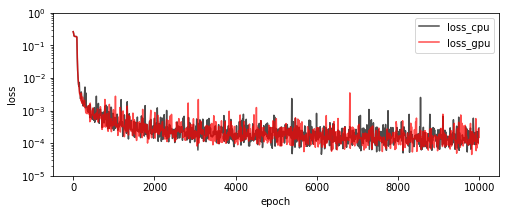

In [11]:
plt.figure(figsize = (8, 3))

plt.plot(model_cpu.ep_log, model_cpu.loss_log, label = "loss_cpu", linestyle = "-", c = "k", alpha = .7)
plt.plot(model_gpu.ep_log, model_gpu.loss_log, label = "loss_gpu", linestyle = "-", c = "r", alpha = .7)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.yscale("log")
plt.ylim(1e-5, 1e0)
plt.legend()

l2 norm difference in CPU version: 0.007415892472867893
l2 norm difference in GPU version: 0.009770958982428045


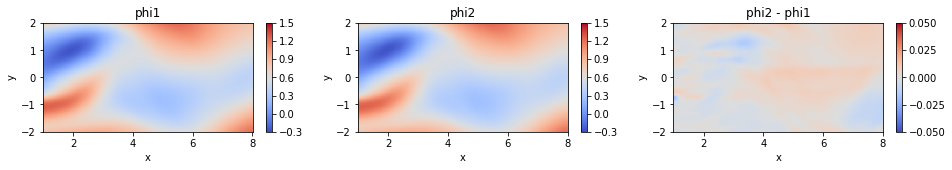

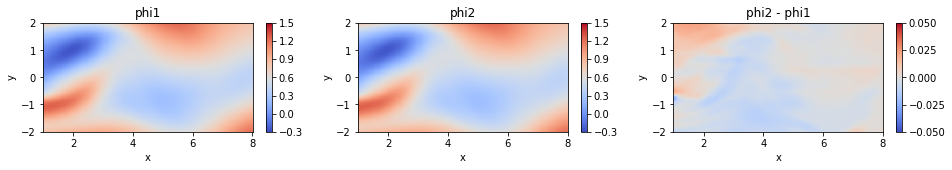

In [12]:
tm = 100
tm = np.array([tm])
x_star    = X_star[:,0:1]; y_star    = X_star[:,1:2]; t_star    = TT[:,tm]
u_star    = UU   [:,tm];   v_star    = VV   [:,tm];   p_star    = PP[:,tm]
u_star_ns = UU_ns[:,tm];   v_star_ns = VV_ns[:,tm];   p_star_ns = PP_ns[:,tm]

u_hat1, v_hat1, p_hat1, gv_c_hat1, gv_x_hat1, gv_y_hat1 = model_cpu.predict(x_star, y_star, t_star)
u_hat2, v_hat2, p_hat2, gv_c_hat2, gv_x_hat2, gv_y_hat2 = model_gpu.predict(x_star, y_star, t_star)

print("l2 norm difference in CPU version:", np.linalg.norm(u_star - u_hat1, 2) / np.linalg.norm(u_star, 2))
print("l2 norm difference in GPU version:", np.linalg.norm(u_star - u_hat2, 2) / np.linalg.norm(u_star, 2))

plot_diff(X_star, u_star, u_hat1.numpy(), u0, u1, ut)
plot_diff(X_star, u_star, u_hat2.numpy(), u0, u1, ut)

In [13]:
# test 2
# use GPU, and see performance improvement due to NN size increase (or, perhaps plateau)
# 4 cases - 7 * [20] / 7 * [200] / 7 * [400] / 7 * [600]

batch_size = 2 ** 7      # 2 ** 7 = 128
max_epoch  = int(1e4)
c_tol      = 1e-8        # avoid early termination

In [14]:
layers = [3] + 7 * [20] + [3]

t0 = time.time()

print("""
************************************************************
****************     MAIN PROGRAM START     ****************
************************************************************
""", ">>>>> start time:", datetime.datetime.now())

seed    = 1234
np.random.seed(seed)
tf.random.set_seed(seed)

model_20 = PINN_minibatch(x_trn, y_trn, t_trn, u_trn, v_trn, 
                          x_val, y_val, t_val, u_val, v_val, 
                          layers, activ = "tanh", w_init = "Glorot", 
                          lr = 1e-3, opt = "Adam", 
                          w_prd = 1., w_pde = 1.)

with tf.device("/device:GPU:0"):
    model_20.train(epoch = max_epoch, batch = batch_size, tol = c_tol)

print("""
************************************************************
*****************     MAIN PROGRAM END     *****************
************************************************************
""", ">>>>> end time:", datetime.datetime.now())
t1 = time.time()

print("elps (min):", (t1 - t0) / 60.)
print("elps  (hr):", (t1 - t0) / 60. / 60.)


************************************************************
****************     MAIN PROGRAM START     ****************
************************************************************
 >>>>> start time: 2021-10-16 03:44:58.657734
ep: 0, loss_trn: 2.859252e-01, elps: 7.473
>>>>> initial state; loss_trn: 2.275534e-01, loss_val: 2.275754e-01
ep: 10, loss_trn: 1.959595e-01, elps: 9.200
ep: 20, loss_trn: 1.887534e-01, elps: 8.943
ep: 30, loss_trn: 1.851347e-01, elps: 9.030
ep: 40, loss_trn: 1.810382e-01, elps: 8.859
ep: 50, loss_trn: 1.794297e-01, elps: 8.976
ep: 60, loss_trn: 1.795281e-01, elps: 8.989
ep: 70, loss_trn: 1.779497e-01, elps: 8.999
ep: 80, loss_trn: 1.758687e-01, elps: 9.041
ep: 90, loss_trn: 1.605445e-01, elps: 8.935
ep: 100, loss_trn: 5.665113e-02, elps: 9.024
ep: 110, loss_trn: 3.297492e-02, elps: 8.911
ep: 120, loss_trn: 2.568968e-02, elps: 8.910
ep: 130, loss_trn: 2.162842e-02, elps: 8.935
ep: 140, loss_trn: 1.928040e-02, elps: 8.991
ep: 150, loss_trn: 1.702097e-02, elps:

In [27]:
layers = [3] + 7 * [200] + [3]

t0 = time.time()

print("""
************************************************************
****************     MAIN PROGRAM START     ****************
************************************************************
""", ">>>>> start time:", datetime.datetime.now())

seed    = 1234
np.random.seed(seed)
tf.random.set_seed(seed)

model_200 = PINN_minibatch(x_trn, y_trn, t_trn, u_trn, v_trn, 
                          x_val, y_val, t_val, u_val, v_val, 
                          layers, activ = "tanh", w_init = "Glorot", 
                          lr = 1e-3, opt = "Adam", 
                          w_prd = 1., w_pde = 1.)

with tf.device("/device:GPU:0"):
    model_200.train(epoch = max_epoch*1, batch = batch_size, tol = c_tol)

print("""
************************************************************
*****************     MAIN PROGRAM END     *****************
************************************************************
""", ">>>>> end time:", datetime.datetime.now())
t1 = time.time()

print("elps (min):", (t1 - t0) / 60.)
print("elps  (hr):", (t1 - t0) / 60. / 60.)


************************************************************
****************     MAIN PROGRAM START     ****************
************************************************************
 >>>>> start time: 2021-10-16 13:03:11.325336
ep: 0, loss_trn: 2.622458e-01, elps: 7.177
>>>>> initial state; loss_trn: 2.294655e-01, loss_val: 2.307147e-01
ep: 10, loss_trn: 2.331354e-01, elps: 8.889
ep: 20, loss_trn: 1.956133e-01, elps: 8.188
ep: 30, loss_trn: 1.891263e-01, elps: 8.409
ep: 40, loss_trn: 1.876592e-01, elps: 8.327
ep: 50, loss_trn: 1.863640e-01, elps: 8.403
ep: 60, loss_trn: 1.869139e-01, elps: 8.459
ep: 70, loss_trn: 1.876246e-01, elps: 8.344
ep: 80, loss_trn: 1.827277e-01, elps: 8.283
ep: 90, loss_trn: 1.784897e-01, elps: 8.305
ep: 100, loss_trn: 5.508111e-02, elps: 8.483
ep: 110, loss_trn: 1.779925e-02, elps: 8.006
ep: 120, loss_trn: 9.723193e-03, elps: 8.235
ep: 130, loss_trn: 7.038766e-03, elps: 8.579
ep: 140, loss_trn: 4.967624e-03, elps: 8.605
ep: 150, loss_trn: 3.872134e-03, elps:

In [28]:
layers = [3] + 7 * [400] + [3]

t0 = time.time()

print("""
************************************************************
****************     MAIN PROGRAM START     ****************
************************************************************
""", ">>>>> start time:", datetime.datetime.now())

seed    = 1234
np.random.seed(seed)
tf.random.set_seed(seed)

model_400 = PINN_minibatch(x_trn, y_trn, t_trn, u_trn, v_trn, 
                          x_val, y_val, t_val, u_val, v_val, 
                          layers, activ = "tanh", w_init = "Glorot", 
                          lr = 1e-3, opt = "Adam", 
                          w_prd = 1., w_pde = 1.)

with tf.device("/device:GPU:0"):
    model_400.train(epoch = max_epoch*2, batch = batch_size, tol = c_tol)

print("""
************************************************************
*****************     MAIN PROGRAM END     *****************
************************************************************
""", ">>>>> end time:", datetime.datetime.now())
t1 = time.time()

print("elps (min):", (t1 - t0) / 60.)
print("elps  (hr):", (t1 - t0) / 60. / 60.)


************************************************************
****************     MAIN PROGRAM START     ****************
************************************************************
 >>>>> start time: 2021-10-16 15:17:47.132259
ep: 0, loss_trn: 2.711322e-01, elps: 7.392
>>>>> initial state; loss_trn: 2.291608e-01, loss_val: 2.306238e-01
ep: 10, loss_trn: 2.332045e-01, elps: 8.837
ep: 20, loss_trn: 1.927947e-01, elps: 8.480
ep: 30, loss_trn: 1.897006e-01, elps: 8.590
ep: 40, loss_trn: 1.893724e-01, elps: 8.576
ep: 50, loss_trn: 1.869120e-01, elps: 8.624
ep: 60, loss_trn: 1.871291e-01, elps: 8.448
ep: 70, loss_trn: 1.866505e-01, elps: 8.662
ep: 80, loss_trn: 1.839774e-01, elps: 8.533
ep: 90, loss_trn: 1.818539e-01, elps: 8.462
ep: 100, loss_trn: 1.826561e-01, elps: 8.507
ep: 110, loss_trn: 1.813985e-01, elps: 8.120
ep: 120, loss_trn: 7.796030e-02, elps: 8.459
ep: 130, loss_trn: 1.845994e-02, elps: 8.405
ep: 140, loss_trn: 1.146724e-02, elps: 8.668
ep: 150, loss_trn: 6.466539e-03, elps:

In [29]:
layers = [3] + 7 * [600] + [3]

t0 = time.time()

print("""
************************************************************
****************     MAIN PROGRAM START     ****************
************************************************************
""", ">>>>> start time:", datetime.datetime.now())

seed    = 1234
np.random.seed(seed)
tf.random.set_seed(seed)

model_600 = PINN_minibatch(x_trn, y_trn, t_trn, u_trn, v_trn, 
                          x_val, y_val, t_val, u_val, v_val, 
                          layers, activ = "tanh", w_init = "Glorot", 
                          lr = 1e-3, opt = "Adam", 
                          w_prd = 1., w_pde = 1.)

with tf.device("/device:GPU:0"):
    model_600.train(epoch = max_epoch*3, batch = batch_size, tol = c_tol)

print("""
************************************************************
*****************     MAIN PROGRAM END     *****************
************************************************************
""", ">>>>> end time:", datetime.datetime.now())
t1 = time.time()

print("elps (min):", (t1 - t0) / 60.)
print("elps  (hr):", (t1 - t0) / 60. / 60.)


************************************************************
****************     MAIN PROGRAM START     ****************
************************************************************
 >>>>> start time: 2021-10-16 19:58:34.974608
ep: 0, loss_trn: 3.044216e-01, elps: 7.097
>>>>> initial state; loss_trn: 2.288826e-01, loss_val: 2.299927e-01
ep: 10, loss_trn: 2.334678e-01, elps: 9.218
ep: 20, loss_trn: 2.313240e-01, elps: 8.948
ep: 30, loss_trn: 2.306511e-01, elps: 8.871
ep: 40, loss_trn: 1.992323e-01, elps: 9.009
ep: 50, loss_trn: 1.936847e-01, elps: 9.011
ep: 60, loss_trn: 1.923128e-01, elps: 8.938
ep: 70, loss_trn: 1.928836e-01, elps: 9.030
ep: 80, loss_trn: 1.898902e-01, elps: 9.028
ep: 90, loss_trn: 1.869458e-01, elps: 9.063
ep: 100, loss_trn: 1.883503e-01, elps: 8.993
ep: 110, loss_trn: 1.872687e-01, elps: 9.026
ep: 120, loss_trn: 1.848472e-01, elps: 8.967
ep: 130, loss_trn: 8.121387e+02, elps: 9.000
ep: 140, loss_trn: 1.119618e+02, elps: 9.013
ep: 150, loss_trn: 6.959403e+01, elps:

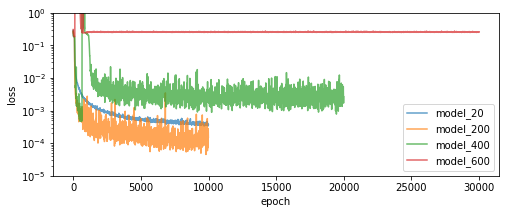

In [30]:
plt.figure(figsize = (8, 3))

plt.plot(model_20.ep_log,  model_20.loss_log,  label = "model_20",  linestyle = "-", alpha = .7)
plt.plot(model_200.ep_log, model_200.loss_log, label = "model_200", linestyle = "-", alpha = .7)
plt.plot(model_400.ep_log, model_400.loss_log, label = "model_400", linestyle = "-", alpha = .7)
plt.plot(model_600.ep_log, model_600.loss_log, label = "model_600", linestyle = "-", alpha = .7)

plt.xlabel("epoch")
plt.ylabel("loss")
plt.yscale("log")
plt.ylim(1e-5, 1e0)
plt.legend()

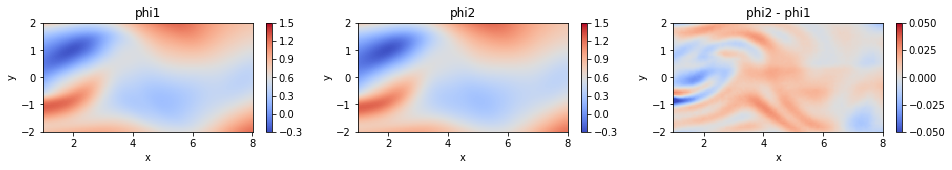

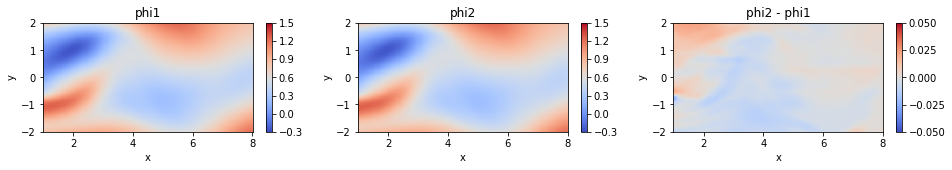

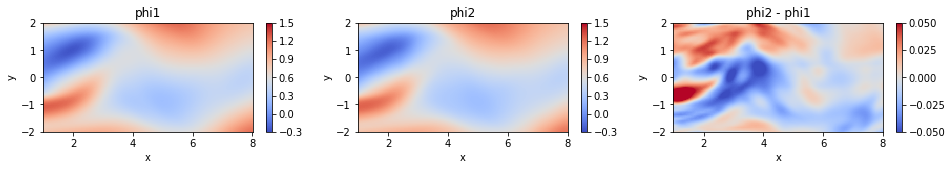

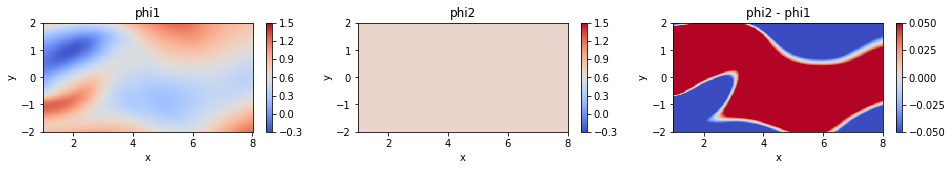

In [31]:
tm = 100
tm = np.array([tm])
x_star    = X_star[:,0:1]; y_star    = X_star[:,1:2]; t_star    = TT[:,tm]
u_star    = UU   [:,tm];   v_star    = VV   [:,tm];   p_star    = PP[:,tm]
u_star_ns = UU_ns[:,tm];   v_star_ns = VV_ns[:,tm];   p_star_ns = PP_ns[:,tm]

u_hat_20,  v_hat_20,  p_hat_20,  gv_c_hat_20,  gv_x_hat_20,  gv_y_hat_20  = model_20.predict(x_star, y_star, t_star)
u_hat_200, v_hat_200, p_hat_200, gv_c_hat_200, gv_x_hat_200, gv_y_hat_200 = model_200.predict(x_star, y_star, t_star)
u_hat_400, v_hat_400, p_hat_400, gv_c_hat_400, gv_x_hat_400, gv_y_hat_400 = model_400.predict(x_star, y_star, t_star)
u_hat_600, v_hat_600, p_hat_600, gv_c_hat_600, gv_x_hat_600, gv_y_hat_600 = model_600.predict(x_star, y_star, t_star)

plot_diff(X_star, u_star, u_hat_20.numpy(),  u0, u1, ut)
plot_diff(X_star, u_star, u_hat_200.numpy(), u0, u1, ut)
plot_diff(X_star, u_star, u_hat_400.numpy(), u0, u1, ut)
plot_diff(X_star, u_star, u_hat_600.numpy(), u0, u1, ut)

In [20]:
layers  = [3] + 7 * [100] + [3]
batch_size = 2 ** 7

model_pr = PINN_minibatch(x_trn, y_trn, t_trn, u_trn, v_trn, 
                          x_val, y_val, t_val, u_val, v_val, 
                          layers, activ = "tanh", w_init = "Glorot", 
                          lr = 1e-3, opt = "Adam", 
                          w_prd = 1., w_pde = 1.)

t0 = time.time()

print("********** EXEC ON CPU ********** ")
print("********** EXEC ON CPU ********** ")
print("********** EXEC ON CPU ********** ")
with tf.device("/device:CPU:0"):
    model_pr.train(epoch = int(30), batch = batch_size, tol = 1e-5)


model_pr = PINN_minibatch(x_trn, y_trn, t_trn, u_trn, v_trn, 
                          x_val, y_val, t_val, u_val, v_val, 
                          layers, activ = "tanh", w_init = "Glorot", 
                          lr = 1e-3, opt = "Adam", 
                          w_prd = 1., w_pde = 1.)

print("********** EXEC ON GPU **********")
print("********** EXEC ON GPU **********")
print("********** EXEC ON GPU **********")
with tf.device("/device:GPU:0"):
    model_pr.train(epoch = int(30), batch = batch_size, tol = 1e-5)

t1 = time.time()

print("elaps (min):", (t1 - t0) / 60.)

********** EXEC ON CPU ********** 
********** EXEC ON CPU ********** 
********** EXEC ON CPU ********** 
ep: 0, loss_trn: 2.692590e-01, elps: 6.988
>>>>> initial state; loss_trn: 2.274664e-01, loss_val: 2.280355e-01
ep: 10, loss_trn: 2.297622e-01, elps: 4.284
ep: 20, loss_trn: 1.906984e-01, elps: 3.488
********** EXEC ON GPU **********
********** EXEC ON GPU **********
********** EXEC ON GPU **********
ep: 0, loss_trn: 2.702833e-01, elps: 7.251
>>>>> initial state; loss_trn: 2.263484e-01, loss_val: 2.272133e-01
ep: 10, loss_trn: 2.296988e-01, elps: 8.542
ep: 20, loss_trn: 1.914484e-01, elps: 8.477
elaps (min): 0.8271491010983785


In [21]:
layers  = [3] + 7 * [200] + [3]
batch_size = 2 ** 7

model_pr = PINN_minibatch(x_trn, y_trn, t_trn, u_trn, v_trn, 
                          x_val, y_val, t_val, u_val, v_val, 
                          layers, activ = "tanh", w_init = "Glorot", 
                          lr = 1e-3, opt = "Adam", 
                          w_prd = 1., w_pde = 1.)

t0 = time.time()

print("********** EXEC ON CPU ********** ")
print("********** EXEC ON CPU ********** ")
print("********** EXEC ON CPU ********** ")
with tf.device("/device:CPU:0"):
    model_pr.train(epoch = int(30), batch = batch_size, tol = 1e-5)

model_pr = PINN_minibatch(x_trn, y_trn, t_trn, u_trn, v_trn, 
                          x_val, y_val, t_val, u_val, v_val, 
                          layers, activ = "tanh", w_init = "Glorot", 
                          lr = 1e-3, opt = "Adam", 
                          w_prd = 1., w_pde = 1.)


print("********** EXEC ON GPU **********")
print("********** EXEC ON GPU **********")
print("********** EXEC ON GPU **********")
with tf.device("/device:GPU:0"):
    model_pr.train(epoch = int(30), batch = batch_size, tol = 1e-5)

t1 = time.time()

print("elaps (min):", (t1 - t0) / 60.)

********** EXEC ON CPU ********** 
********** EXEC ON CPU ********** 
********** EXEC ON CPU ********** 
ep: 0, loss_trn: 2.621862e-01, elps: 7.138
>>>>> initial state; loss_trn: 2.292920e-01, loss_val: 2.306375e-01
ep: 10, loss_trn: 2.296616e-01, elps: 8.657
ep: 20, loss_trn: 1.944948e-01, elps: 7.288
********** EXEC ON GPU **********
********** EXEC ON GPU **********
********** EXEC ON GPU **********
ep: 0, loss_trn: 2.612735e-01, elps: 7.216
>>>>> initial state; loss_trn: 2.288509e-01, loss_val: 2.288482e-01
ep: 10, loss_trn: 2.314567e-01, elps: 7.728
ep: 20, loss_trn: 1.937345e-01, elps: 7.619
elaps (min): 0.9831235806147257


In [22]:
layers  = [3] + 7 * [300] + [3]
batch_size = 2 ** 7

model_pr = PINN_minibatch(x_trn, y_trn, t_trn, u_trn, v_trn, 
                          x_val, y_val, t_val, u_val, v_val, 
                          layers, activ = "tanh", w_init = "Glorot", 
                          lr = 1e-3, opt = "Adam", 
                          w_prd = 1., w_pde = 1.)

t0 = time.time()

print("********** EXEC ON CPU ********** ")
print("********** EXEC ON CPU ********** ")
print("********** EXEC ON CPU ********** ")
with tf.device("/device:CPU:0"):
    model_pr.train(epoch = int(30), batch = batch_size, tol = 1e-5)

model_pr = PINN_minibatch(x_trn, y_trn, t_trn, u_trn, v_trn, 
                          x_val, y_val, t_val, u_val, v_val, 
                          layers, activ = "tanh", w_init = "Glorot", 
                          lr = 1e-3, opt = "Adam", 
                          w_prd = 1., w_pde = 1.)

print("********** EXEC ON GPU **********")
print("********** EXEC ON GPU **********")
print("********** EXEC ON GPU **********")
with tf.device("/device:GPU:0"):
    model_pr.train(epoch = int(30), batch = batch_size, tol = 1e-5)

t1 = time.time()

print("elaps (min):", (t1 - t0) / 60.)

********** EXEC ON CPU ********** 
********** EXEC ON CPU ********** 
********** EXEC ON CPU ********** 
ep: 0, loss_trn: 2.669472e-01, elps: 7.462
>>>>> initial state; loss_trn: 2.291768e-01, loss_val: 2.295481e-01
ep: 10, loss_trn: 2.320297e-01, elps: 12.646
ep: 20, loss_trn: 1.932919e-01, elps: 10.636
********** EXEC ON GPU **********
********** EXEC ON GPU **********
********** EXEC ON GPU **********
ep: 0, loss_trn: 2.685955e-01, elps: 7.125
>>>>> initial state; loss_trn: 2.317765e-01, loss_val: 2.333697e-01
ep: 10, loss_trn: 2.317254e-01, elps: 8.844
ep: 20, loss_trn: 1.917319e-01, elps: 8.625
elaps (min): 1.213136343161265


In [23]:
layers  = [3] + 7 * [400] + [3]
batch_size = 2 ** 7

model_pr = PINN_minibatch(x_trn, y_trn, t_trn, u_trn, v_trn, 
                          x_val, y_val, t_val, u_val, v_val, 
                          layers, activ = "tanh", w_init = "Glorot", 
                          lr = 1e-3, opt = "Adam", 
                          w_prd = 1., w_pde = 1.)

t0 = time.time()

print("********** EXEC ON CPU ********** ")
print("********** EXEC ON CPU ********** ")
print("********** EXEC ON CPU ********** ")
with tf.device("/device:CPU:0"):
    model_pr.train(epoch = int(30), batch = batch_size, tol = 1e-5)

model_pr = PINN_minibatch(x_trn, y_trn, t_trn, u_trn, v_trn, 
                          x_val, y_val, t_val, u_val, v_val, 
                          layers, activ = "tanh", w_init = "Glorot", 
                          lr = 1e-3, opt = "Adam", 
                          w_prd = 1., w_pde = 1.)

print("********** EXEC ON GPU **********")
print("********** EXEC ON GPU **********")
print("********** EXEC ON GPU **********")
with tf.device("/device:GPU:0"):
    model_pr.train(epoch = int(30), batch = batch_size, tol = 1e-5)

t1 = time.time()

print("elaps (min):", (t1 - t0) / 60.)

********** EXEC ON CPU ********** 
********** EXEC ON CPU ********** 
********** EXEC ON CPU ********** 
ep: 0, loss_trn: 2.730557e-01, elps: 7.921
>>>>> initial state; loss_trn: 2.263144e-01, loss_val: 2.271624e-01
ep: 10, loss_trn: 2.322360e-01, elps: 17.516
ep: 20, loss_trn: 1.928032e-01, elps: 15.252
********** EXEC ON GPU **********
********** EXEC ON GPU **********
********** EXEC ON GPU **********
ep: 0, loss_trn: 2.730304e-01, elps: 7.238
>>>>> initial state; loss_trn: 2.275554e-01, loss_val: 2.277034e-01
ep: 10, loss_trn: 2.334747e-01, elps: 9.114
ep: 20, loss_trn: 1.939940e-01, elps: 8.744
elaps (min): 1.458706557750702


In [24]:
layers  = [3] + 7 * [500] + [3]
batch_size = 2 ** 7

model_pr = PINN_minibatch(x_trn, y_trn, t_trn, u_trn, v_trn, 
                          x_val, y_val, t_val, u_val, v_val, 
                          layers, activ = "tanh", w_init = "Glorot", 
                          lr = 1e-3, opt = "Adam", 
                          w_prd = 1., w_pde = 1.)

t0 = time.time()

print("********** EXEC ON CPU ********** ")
print("********** EXEC ON CPU ********** ")
print("********** EXEC ON CPU ********** ")
with tf.device("/device:CPU:0"):
    model_pr.train(epoch = int(30), batch = batch_size, tol = 1e-5)

model_pr = PINN_minibatch(x_trn, y_trn, t_trn, u_trn, v_trn, 
                          x_val, y_val, t_val, u_val, v_val, 
                          layers, activ = "tanh", w_init = "Glorot", 
                          lr = 1e-3, opt = "Adam", 
                          w_prd = 1., w_pde = 1.)

print("********** EXEC ON GPU **********")
print("********** EXEC ON GPU **********")
print("********** EXEC ON GPU **********")
with tf.device("/device:GPU:0"):
    model_pr.train(epoch = int(30), batch = batch_size, tol = 1e-5)

t1 = time.time()

print("elaps (min):", (t1 - t0) / 60.)

********** EXEC ON CPU ********** 
********** EXEC ON CPU ********** 
********** EXEC ON CPU ********** 
ep: 0, loss_trn: 2.966600e-01, elps: 8.197
>>>>> initial state; loss_trn: 2.329361e-01, loss_val: 2.339753e-01
ep: 10, loss_trn: 2.315303e-01, elps: 23.824
ep: 20, loss_trn: 1.953219e-01, elps: 20.921
********** EXEC ON GPU **********
********** EXEC ON GPU **********
********** EXEC ON GPU **********
ep: 0, loss_trn: 2.912320e-01, elps: 7.253
>>>>> initial state; loss_trn: 2.285385e-01, loss_val: 2.282452e-01
ep: 10, loss_trn: 2.328010e-01, elps: 7.705
ep: 20, loss_trn: 2.231524e-01, elps: 7.795
elaps (min): 1.6934184114138284


In [25]:
layers  = [3] + 7 * [750] + [3]
batch_size = 2 ** 7

model_pr = PINN_minibatch(x_trn, y_trn, t_trn, u_trn, v_trn, 
                          x_val, y_val, t_val, u_val, v_val, 
                          layers, activ = "tanh", w_init = "Glorot", 
                          lr = 1e-3, opt = "Adam", 
                          w_prd = 1., w_pde = 1.)

t0 = time.time()

print("********** EXEC ON CPU ********** ")
print("********** EXEC ON CPU ********** ")
print("********** EXEC ON CPU ********** ")
with tf.device("/device:CPU:0"):
    model_pr.train(epoch = int(30), batch = batch_size, tol = 1e-5)

model_pr = PINN_minibatch(x_trn, y_trn, t_trn, u_trn, v_trn, 
                          x_val, y_val, t_val, u_val, v_val, 
                          layers, activ = "tanh", w_init = "Glorot", 
                          lr = 1e-3, opt = "Adam", 
                          w_prd = 1., w_pde = 1.)

print("********** EXEC ON GPU **********")
print("********** EXEC ON GPU **********")
print("********** EXEC ON GPU **********")
with tf.device("/device:GPU:0"):
    model_pr.train(epoch = int(30), batch = batch_size, tol = 1e-5)

t1 = time.time()

print("elaps (min):", (t1 - t0) / 60.)

********** EXEC ON CPU ********** 
********** EXEC ON CPU ********** 
********** EXEC ON CPU ********** 
ep: 0, loss_trn: 3.440161e-01, elps: 11.000
>>>>> initial state; loss_trn: 2.278509e-01, loss_val: 2.279316e-01
ep: 10, loss_trn: 2.319658e-01, elps: 48.364
ep: 20, loss_trn: 1.952819e-01, elps: 43.582
********** EXEC ON GPU **********
********** EXEC ON GPU **********
********** EXEC ON GPU **********
ep: 0, loss_trn: 3.275055e-01, elps: 7.504
>>>>> initial state; loss_trn: 2.328059e-01, loss_val: 2.322460e-01
ep: 10, loss_trn: 2.314386e-01, elps: 9.312
ep: 20, loss_trn: 2.312236e-01, elps: 8.999
elaps (min): 2.939935493469238


In [26]:
layers  = [3] + 7 * [1000] + [3]
batch_size = 2 ** 7

model_pr = PINN_minibatch(x_trn, y_trn, t_trn, u_trn, v_trn, 
                          x_val, y_val, t_val, u_val, v_val, 
                          layers, activ = "tanh", w_init = "Glorot", 
                          lr = 1e-3, opt = "Adam", 
                          w_prd = 1., w_pde = 1.)

t0 = time.time()

print("********** EXEC ON CPU ********** ")
print("********** EXEC ON CPU ********** ")
print("********** EXEC ON CPU ********** ")
with tf.device("/device:CPU:0"):
    model_pr.train(epoch = int(30), batch = batch_size, tol = 1e-5)

model_pr = PINN_minibatch(x_trn, y_trn, t_trn, u_trn, v_trn, 
                          x_val, y_val, t_val, u_val, v_val, 
                          layers, activ = "tanh", w_init = "Glorot", 
                          lr = 1e-3, opt = "Adam", 
                          w_prd = 1., w_pde = 1.)

print("********** EXEC ON GPU **********")
print("********** EXEC ON GPU **********")
print("********** EXEC ON GPU **********")
with tf.device("/device:GPU:0"):
    model_pr.train(epoch = int(30), batch = batch_size, tol = 1e-5)

t1 = time.time()

print("elaps (min):", (t1 - t0) / 60.)

********** EXEC ON CPU ********** 
********** EXEC ON CPU ********** 
********** EXEC ON CPU ********** 
ep: 0, loss_trn: 4.591027e-01, elps: 12.480
>>>>> initial state; loss_trn: 2.352723e-01, loss_val: 2.361770e-01
ep: 10, loss_trn: 2.349351e-01, elps: 70.363
ep: 20, loss_trn: 2.328148e-01, elps: 63.670
********** EXEC ON GPU **********
********** EXEC ON GPU **********
********** EXEC ON GPU **********
ep: 0, loss_trn: 5.081843e-01, elps: 7.268
>>>>> initial state; loss_trn: 2.302069e-01, loss_val: 2.311846e-01
ep: 10, loss_trn: 2.320142e-01, elps: 7.986
ep: 20, loss_trn: 2.306711e-01, elps: 7.526
elaps (min): 3.895231823126475
